In [158]:
import math
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [210]:
dataset = pd.read_csv('./Data/mergedFiles(2).csv', header=0, index_col=0, usecols=[0, 1,2,27,28])
values = dataset.values
values = values.astype('float32')

In [211]:
dataset.head()

,Byron Bay (Belongil Creek),Clarrie Hall Dam (Doon Doon Creek),Mullumbimby (Upper Main Arm).1,Goonengerry.1
date,,,,
2006-02-08,2.75,2.50,3.0,5.0
2006-02-09,0.25,2.00,0.5,0.5
2006-02-12,6.50,19.50,7.0,10.5
2006-02-13,7.00,21.75,0.0,4.0
2006-02-14,0.00,0.75,5.5,0.0


In [212]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [213]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,-1] = encoder.fit_transform(values[:,-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.001665   0.002796   0.003929   0.061728  0.000151  0.002237  0.000655   
2   0.000151   0.002237   0.000655   0.006173  0.003936  0.021812  0.009168   
3   0.003936   0.021812   0.009168   0.129630  0.004239  0.024329  0.000000   
4   0.004239   0.024329   0.000000   0.049383  0.000000  0.000839  0.007204   
5   0.000000   0.000839   0.007204   0.000000  0.004087  0.023490  0.029470   

    var4(t)  
1  0.006173  
2  0.129630  
3  0.049383  
4  0.000000  
5  0.166667  


In [214]:
values = reframed.values
train_size  = int(len(values) * 0.80)
test_size   = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(dataset),:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2015, 1, 7) (2015,) (504, 1, 7) (504,)


Epoch 1/50
2015/2015 - 7s - loss: 0.0198 - val_loss: 0.0178 - 7s/epoch - 3ms/step
Epoch 2/50
2015/2015 - 4s - loss: 0.0164 - val_loss: 0.0198 - 4s/epoch - 2ms/step
Epoch 3/50
2015/2015 - 4s - loss: 0.0160 - val_loss: 0.0204 - 4s/epoch - 2ms/step
Epoch 4/50
2015/2015 - 4s - loss: 0.0157 - val_loss: 0.0205 - 4s/epoch - 2ms/step
Epoch 5/50
2015/2015 - 3s - loss: 0.0154 - val_loss: 0.0205 - 3s/epoch - 2ms/step
Epoch 6/50
2015/2015 - 4s - loss: 0.0151 - val_loss: 0.0202 - 4s/epoch - 2ms/step
Epoch 7/50
2015/2015 - 4s - loss: 0.0147 - val_loss: 0.0198 - 4s/epoch - 2ms/step
Epoch 8/50
2015/2015 - 4s - loss: 0.0144 - val_loss: 0.0193 - 4s/epoch - 2ms/step
Epoch 9/50
2015/2015 - 4s - loss: 0.0140 - val_loss: 0.0187 - 4s/epoch - 2ms/step
Epoch 10/50
2015/2015 - 4s - loss: 0.0136 - val_loss: 0.0181 - 4s/epoch - 2ms/step
Epoch 11/50
2015/2015 - 4s - loss: 0.0132 - val_loss: 0.0174 - 4s/epoch - 2ms/step
Epoch 12/50
2015/2015 - 3s - loss: 0.0127 - val_loss: 0.0166 - 3s/epoch - 2ms/step
Epoch 13/50
2

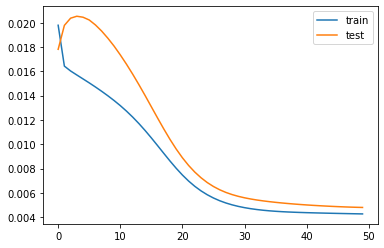

In [215]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [216]:
model.summary()
trainScore = model.evaluate(train_X, train_y, verbose=0)
trainScore = math.sqrt(trainScore)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(test_X, test_y, verbose=0)
testScore = math.sqrt(testScore)
print('Test Score: %.2f RMSE' % (testScore))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50)                11600     
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________
Train Score: 0.07 RMSE
Test Score: 0.07 RMSE


In [202]:
model.save('LSTM.h5')

In [232]:
n_hours = 3
n_features = 10
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(2517, 16)


In [233]:
values = reframed.values
n_train_hours = 4000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [234]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(2517, 16) 2517 (2517,)


In [235]:
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

ValueError: cannot reshape array of size 40272 into shape (2517,3,10)

Epoch 1/50
1800/1800 - 8s - loss: 0.0016 - val_loss: 0.0027 - 8s/epoch - 4ms/step
Epoch 2/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0016 - 4s/epoch - 2ms/step
Epoch 3/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0014 - 4s/epoch - 2ms/step
Epoch 4/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0014 - 4s/epoch - 2ms/step
Epoch 5/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0014 - 4s/epoch - 2ms/step
Epoch 6/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0014 - 4s/epoch - 2ms/step
Epoch 7/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0014 - 4s/epoch - 2ms/step
Epoch 8/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0014 - 4s/epoch - 2ms/step
Epoch 9/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0015 - 4s/epoch - 2ms/step
Epoch 10/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0015 - 4s/epoch - 2ms/step
Epoch 11/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0015 - 4s/epoch - 2ms/step
Epoch 12/50
1800/1800 - 4s - loss: 0.0015 - val_loss: 0.0015 - 4s/epoch - 2ms/step
Epoch 13/50
1

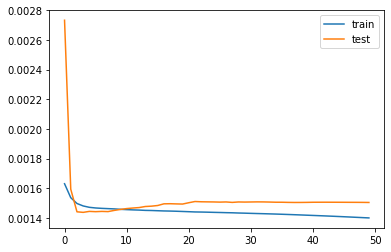

In [193]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()